In [16]:
import pathlib
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import random
import os
import re
from dotenv import load_dotenv
import dspy
import pickle

In [17]:
class Colors:
    BLUE = '\033[94m'
    ENDC = '\033[0m'

In [18]:
# Define the figure size and dpi
fig_width = 6.9  # inches
fig_height = 3.5  # inches
fig_dpi = 350

plt.rcParams.update({
    'figure.figsize': (fig_width, fig_height),
    'figure.dpi': fig_dpi,

    # Fonts
    'font.size': 18,

    # Axes
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'axes.linewidth': 1,
    'axes.grid': True,
    'grid.linestyle': ':',
    'grid.linewidth': 1,
    'grid.color': 'gray',

    # Legend
    'legend.fontsize': 8,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'legend.fancybox': False,
    'legend.edgecolor': 'gray',
    'legend.facecolor': 'white',
    'legend.borderaxespad': 0.5,
    'legend.borderpad': 0.4,
    'legend.labelspacing': 0.5,

    # Lines
    'lines.linewidth': 2.0,
    'lines.markersize': 2,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
})

In [19]:
###########
# API KEY #
###########
path_env = pathlib.Path("/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/.env")
print(path_env)
load_dotenv(path_env)
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

###########
#   LLM   #
###########
llm = dspy.OpenAI(model="gpt-3.5-turbo")# "gpt-4o-2024-05-13")
dspy.settings.configure(lm=llm)


/export/usuarios_ml4ds/lbartolome/NextProcurement/NP-Search-Tool/.env


In [20]:
path_texts = pathlib.Path("/export/data_ml4ds/NextProcurement/PLACE/BSC_procesados")
paths = []
paths = [path for path in path_texts.iterdir()]
print(*paths)

/export/data_ml4ds/NextProcurement/PLACE/BSC_procesados/procurements_file_15_containing_252064_docs_mark_fixed.parq /export/data_ml4ds/NextProcurement/PLACE/BSC_procesados/procurements_file_9_containing_250416_docs_mark_fixed.parq /export/data_ml4ds/NextProcurement/PLACE/BSC_procesados/procurements_file_6_containing_251105_docs_mark_fixed.parq /export/data_ml4ds/NextProcurement/PLACE/BSC_procesados/procurements_file_10_containing_251208_docs_mark_fixed.parq /export/data_ml4ds/NextProcurement/PLACE/BSC_procesados/procurements_file_8_containing_251687_docs_mark_fixed.parq /export/data_ml4ds/NextProcurement/PLACE/BSC_procesados/procurements_file_1_containing_251067_docs_mark_fixed.parq /export/data_ml4ds/NextProcurement/PLACE/BSC_procesados/procurements_file_11_containing_252661_docs_mark_fixed.parq /export/data_ml4ds/NextProcurement/PLACE/BSC_procesados/procurements_file_16_containing_92602_docs_mark_fixed.parq /export/data_ml4ds/NextProcurement/PLACE/BSC_procesados/procurements_file_3_c

In [21]:
this_path = paths[0]
df = pd.read_parquet(this_path)
df

,procurement_id,doc_name,extracted,extracted_tags,texto_heading,embeddings_heading
2,ntp00114200,ntp00114200_Pliego_Prescripciones_tecnicas_URI,g PLIEGO DE PRESCRI PCI ONES TÉCNI CAS\n S\n \...,"[document, section, heading, section, heading,...",[g PLIEGO DE PRESCRI PCI ONES TÉCNI CAS\n S\n ...,"[[-0.1855995, 0.10908591, 0.1287027, -0.085297..."
10,ntp00729859,ntp00729859_Pliego_Prescripciones_tecnicas_URI,PLIEGO DE PRESCRIPCIONES TÉCNICAS QUE HA DE RE...,"[document, section, heading, section, heading,...",[PLIEGO DE PRESCRIPCIONES TÉCNICAS QUE HA DE R...,"[[-0.06488852, 0.03319587, 0.05720649, -0.2051..."
23,ntp01335443,ntp01335443_Pliego_Prescripciones_tecnicas_URI,PLIEGO DE PRESCRIPCIONES TÉCNICAS PARA LA CONT...,"[document, section, heading, body, p, p, p, p,...",[PLIEGO DE PRESCRIPCIONES TÉCNICAS PARA LA CON...,"[[0.11980498, -0.0047292123, 0.07927151, -0.05..."
35,ntp00008052,ntp00008052_Pliego_Prescripciones_tecnicas_URI,íHJJ Agencia de I'Habitatge\n FUU de Catalunya...,"[document, section, heading, section, heading,...",[íHJJ Agencia de I'Habitatge\n FUU de Cataluny...,"[[0.050423447, 0.10861048, 0.12632288, 0.06832..."
40,ntp00196761,ntp00196761_Pliego_Prescripciones_tecnicas_URI,Ref: 50/088288.9/21\nAgencia de Vivienda Socia...,"[document, section, body, p, section, heading,...",[Agencia de Vivienda Social\n CONSEJERÍA DE VI...,"[[0.2535557, 0.06023139, 0.13293944, 0.0011294..."
...,...,...,...,...,...,...
252037,ntp00345950,ntp00345950_Pliego_Prescripciones_tecnicas_URI,">NI'\n-NIMENT, REPARACIONS,\n - LA XARXA DE CL...","[document, section, body, p, section, heading,...","[-NIMENT, REPARACIONS,\n - LA XARXA DE CLAVEGU...","[[-0.23472774, -0.03379578, 0.055891573, 0.129..."
252039,ntp00684402,ntp00684402_Pliego_Prescripciones_tecnicas_URI,PARADORES\nHoteles 8: Restaurantes 1928\nPLIEG...,"[document, section, heading, body, p, section,...","[PARADORES, PLIEGO DE PRESCRIPCIONES TÉCNICAS,...","[[0.12514289, -0.014171446, 0.09959634, 0.0616..."
252041,ntp00328925,ntp00328925_Pliego_Prescripciones_tecnicas_URI,%\n DIPUTACIÓN FORAL DE ÁLAVA\nExpediente 91/2...,"[document, section, heading, body, p, section,...","[%\n DIPUTACIÓN FORAL DE ÁLAVA, PLIEGO DE PRES...","[[0.23495336, -0.0066452846, -0.04699165, 0.00..."
252045,ntp11031769,ntp11031769_Pliego_Prescripciones_tecnicas_URI,"CORTES\n DE., CONTRATO MENOR\n aicie\n Parlame...","[document, section, heading, body, p, section,...","[CORTES\n DE., CONTRATO MENOR\n aicie\n Parlam...","[[-0.011999188, 0.0876619, 0.028823866, -0.060..."


## Analyzing embeddings of the headings

In [5]:
df.texto_heading.iloc[0][2]

'OBJ ETO DEL PLIEGO DE PRESCRI PCIONES TÉCNICAS PARTICULARES'

In [6]:
# Flatten the lists of embeddings and labels
embeddings = []
labels = []

for idx, row in df.iterrows():
    for i, embedding in enumerate(row['embeddings_heading']):
        embeddings.append(embedding)
        labels.append(row['texto_heading'][i])

# Convert to numpy arrays
embeddings = np.array(embeddings)
labels = np.array(labels)

In [7]:
# Apply KMeans clustering
num_clusters = 50
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)
cluster_labels = kmeans.labels_

/home/lbartolome/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [8]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2', device="cuda")
search_label = "objecto del contrato"
search_embedding = model.encode([search_label], show_progress_bar=False)

/home/lbartolome/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
similarities = cosine_similarity(search_embedding, kmeans.cluster_centers_).flatten()
closest_cluster = np.argmax(similarities)

# Filter embeddings and labels belonging to the closest cluster
cluster_indices = np.where(cluster_labels == closest_cluster)[0]
filtered_embeddings = embeddings[cluster_indices]
filtered_labels = labels[cluster_indices]

# Calculate cosine similarity of embeddings to the cluster center
cluster_center = kmeans.cluster_centers_[closest_cluster]
similarities_to_center = cosine_similarity(filtered_embeddings, [cluster_center]).flatten()

In [10]:
# Define a similarity threshold
similarity_threshold = 0.9  # Adjust the threshold as needed

# Filter based on the threshold
filtered_indices = np.where(similarities_to_center >= similarity_threshold)[0]
final_embeddings = filtered_embeddings[filtered_indices]
final_sims = similarities_to_center[filtered_indices]
final_labels = filtered_labels[filtered_indices]
#final_labels

In [23]:
#with open('final_labels.pkl', 'wb') as file:
#    pickle.dump(final_labels, file)
    
with open('final_labels.pkl', 'rb') as file:
    final_labels = pickle.load(file)

In [11]:
sample_array = random.sample(range(0, len(final_embeddings) + 1), 80)

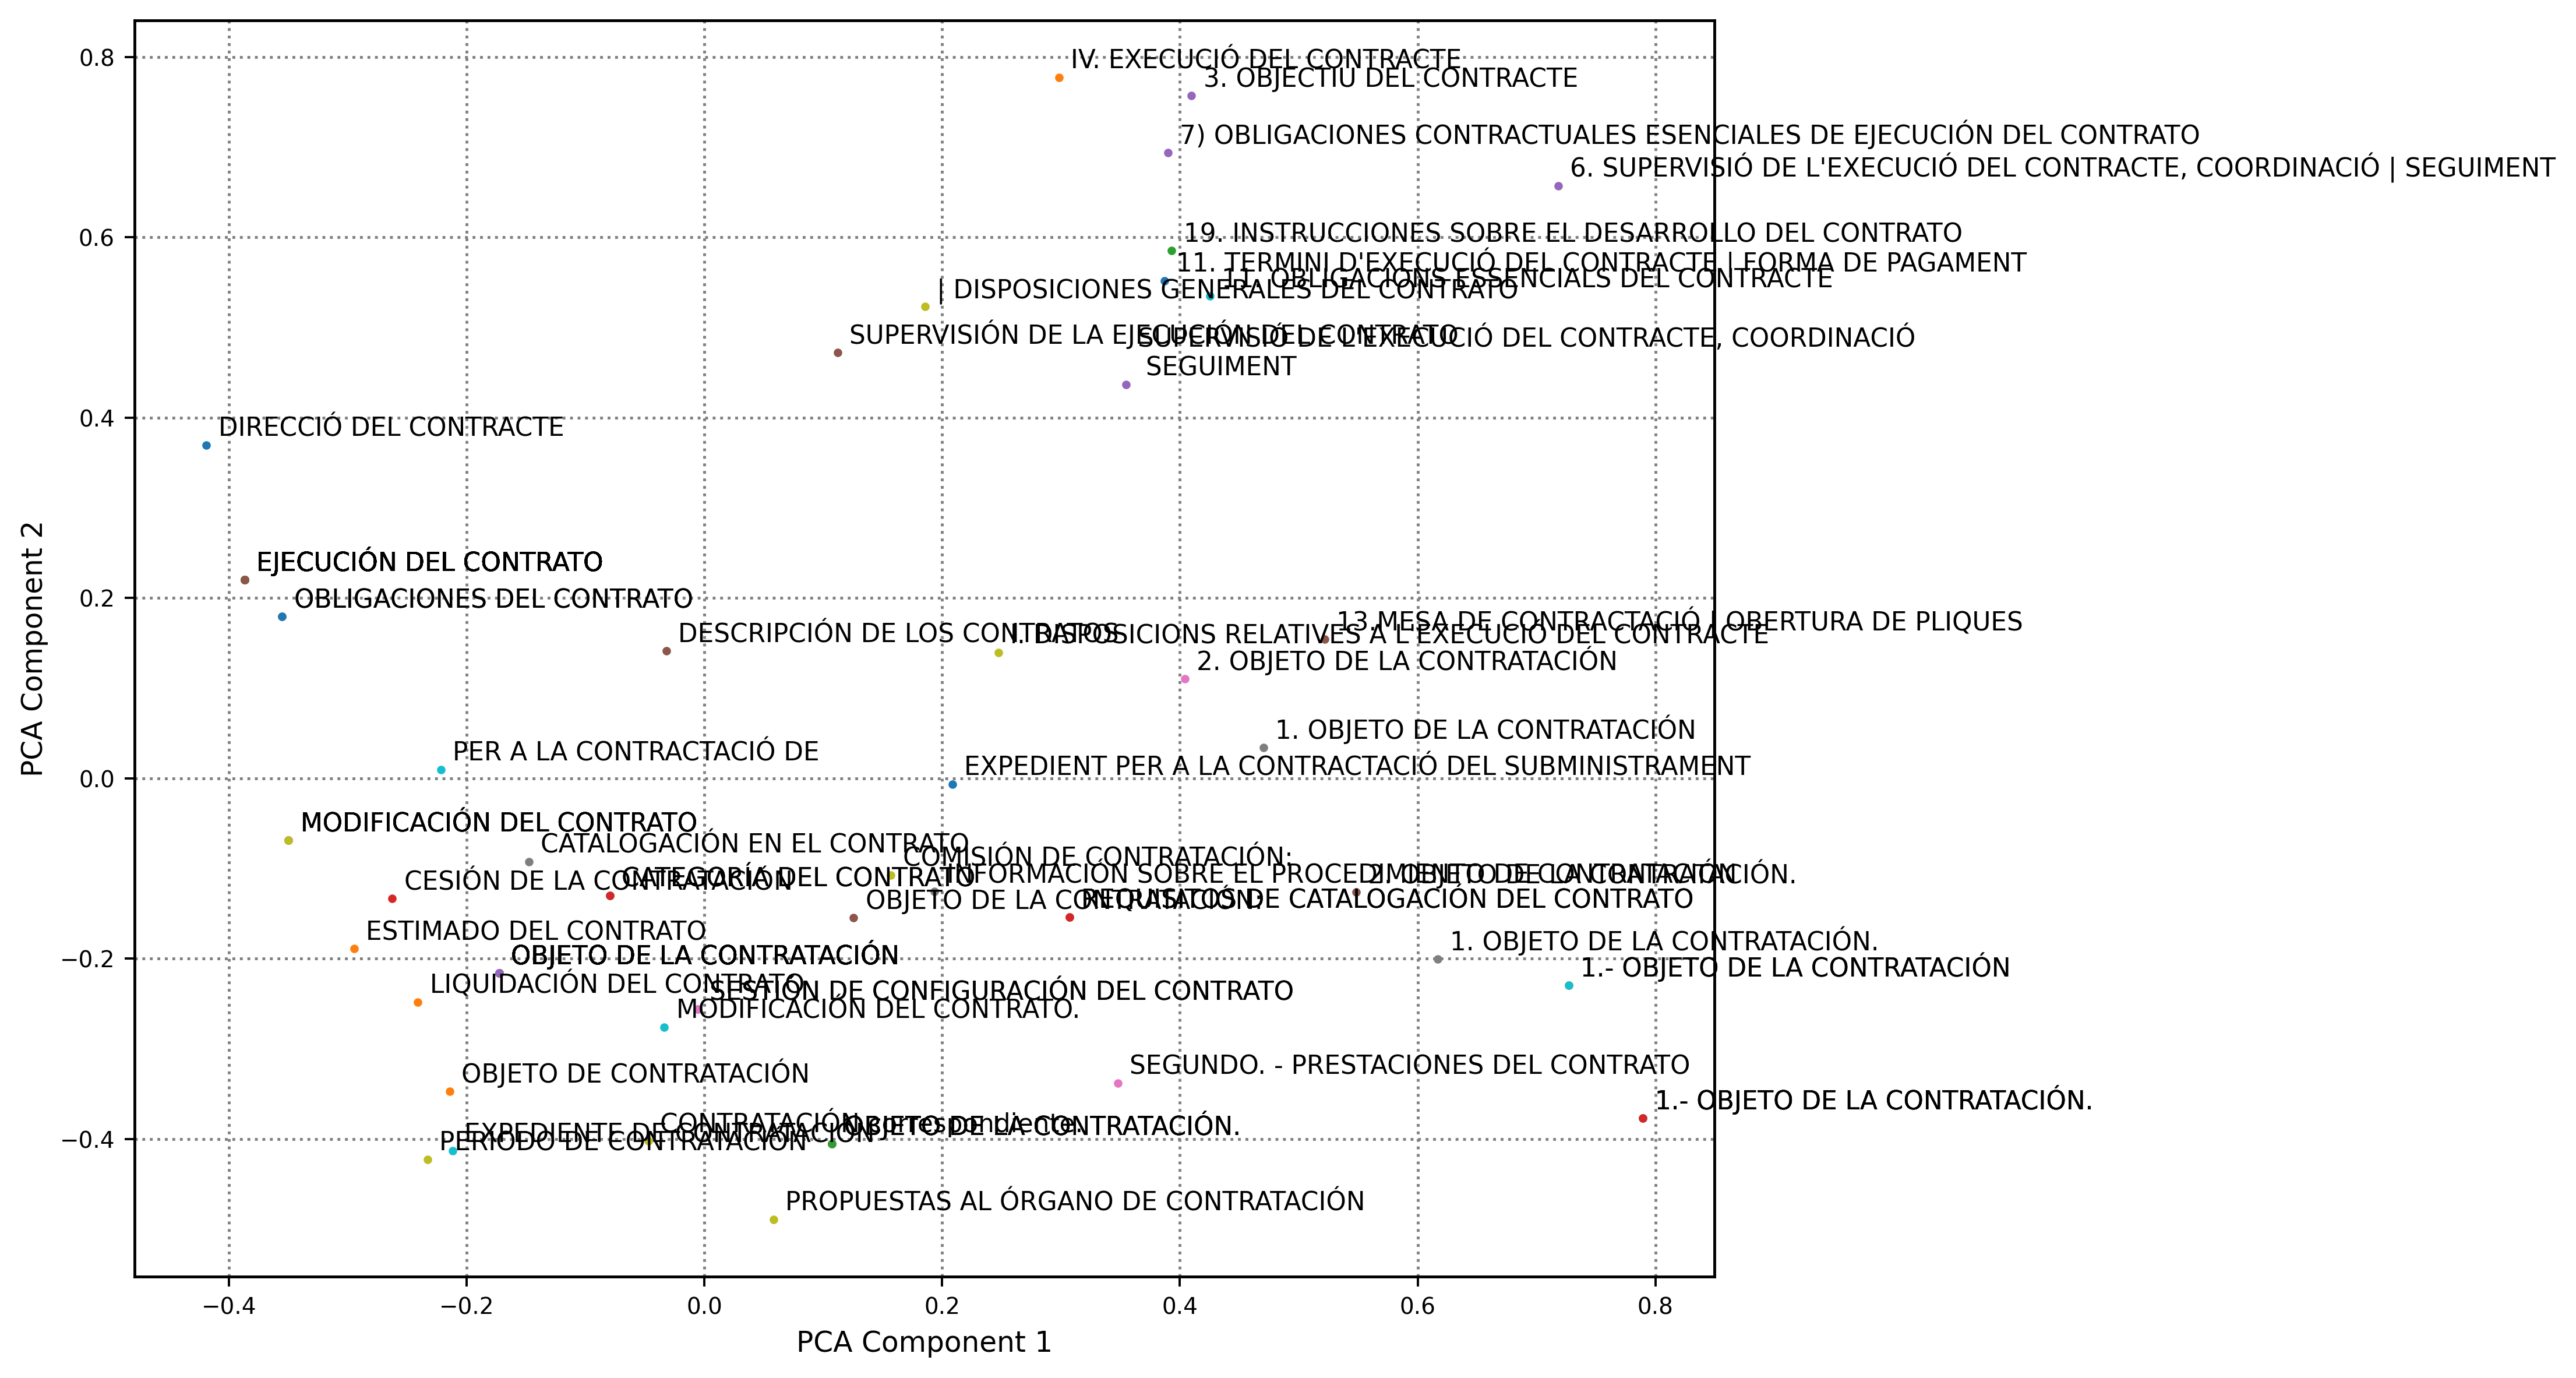

In [12]:
# Reduce dimensionality using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(final_embeddings[sample_array])

# Plot the reduced embeddings
plt.figure(figsize=(10, 8))
for i, label in enumerate(final_labels[sample_array]):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    plt.text(reduced_embeddings[i, 0] + 0.01, reduced_embeddings[i, 1] + 0.01, label, fontsize=9)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## First test extracting OBJETO with DSPY +  ChainOfThoughtWithHint

In [22]:
def clean_text(text):
    """Removes weid characters from the PDF parsing"""

    cleaned_text = re.sub(r'[^\w\s,.]', '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    cleaned_text = re.sub(r'(.)\1{2,}', r'\1', cleaned_text)  # e.g., "eeeee" to "e"
    return cleaned_text

def chunk_test(text, per=0.25):
    """Extracts the initial portion of the text based on the specified percentage."""
    keep_length = int(len(text) * per)    
    return text[:keep_length]

In [24]:
clean_text(chunk_test(df.iloc[0].extracted))

'g PLIEGO DE PRESCRI PCI ONES TÉCNI CAS S CONTRATACIÓN L Suministro de Detector de Equipo de RX Portátil para el Servicio de _g Radiología del Hospital Universitario Central de Asturias. E NÚMERO DE EXPEDI ENTE NS22118 É S q D a D o Pliego de Prescripciones Técnicas para Suministro Detector DRX.HUCA OBJ ETO DEL PLIEGO DE PRESCRI PCIONES TÉCNICAS PARTICULARES El objeto del presente Pliego es la definición de las Prescripciones Técnicas Particulares que han de regir la contratación del Suministro de Detector de equipo de RX Portátil É DRX1 para el Servicio de Radiología del Hospital Universitario Central de Asturias. S 2 OBJETO DEL CONTRATO. Q Z El objeto del contrato que se regirá por el presente Pliego de Prescripciones Técnicas m Particulares es el de realizar los trabajos descritos en el presente Pliego para la empresa o Gestión de Infraestructuras Sanitarias del Principado de Asturias, S.A.U. GISPASA. o ºg 3 JUSTIFICACIÓN DE LOS TRABAJOS. S N La adquisición del equipamiento se motiv

In [25]:
# To use as HINT
def normalize_string(s):
    # Convert to lower case
    s = s.lower()
    # Remove punctuation and special characters
    s = re.sub(r'[^\w\s]', '', s)
    # Remove extra spaces
    s = re.sub(r'\s+', ' ', s).strip()
    return s

normalized_array = np.array([normalize_string(item) for item in final_labels])
unique_dict = {}
for original, normalized in zip(final_labels, normalized_array):
    if normalized not in unique_dict:
        unique_dict[normalized] = original
clean_final_labels = np.array(list(unique_dict.values()))
clean_final_labels

array(['EJECUCIÓN DEL CONTRATO', 'EJECUCIÓN DEL CONTRATE',
       'MODIFICACIÓN DEL CONTRATO.',
       'REQUISITOS DE CATALOGACIÓN DEL CONTRATO',
       'INFORMACIÓN SOBRE EL PROCEDIMIENTO DE CONTRATACIÓN',
       'OBJETO DE LA CONTRATACIÓN', 'OBLIGACIONES DEL CONTRATO',
       'CLAUSULA SEGUNDA: CALIFICACIÓN DEL CONTRATO',
       'COMISIÓN DE CONTRATACIÓN:',
       'INDICIONES DEL CONTRATO: AUTORIZACIONES Y DOCUMENTACIÓN',
       'MODIFICACIÓN DE LOS CONTRATOS',
       'ÓRGANO DE CONTRATACIÓN PROPONENTE:',
       '1. OBJETO DE LA CONTRATACIÓN.',
       'CONDICIONES DE EJECUCIÓN DEL CONTRATO.',
       "TERMINI D'EXECUCIÓ DEL CONTRACTE", 'CATALOGACIÓN DEL CONTRATO',
       'CODIFICACIÓN DEL CONTRATO', 'IBLIGACIONES DEL CONTRATI',
       'PREPARACION DEL CONTRATO', 'ADJUDICACION DEL CONTRATO',
       'CESIÓN DE LA CONTRATACIÓN', 'EPTACIÓN DEL CONTRAT',
       'DESCRIPCIÓN DE LOS CONTRATOS', 'EXPEDIENTE DE CONTRATACIÓN:',
       'OBJETO DE CONTRATACIÓN', '1. OBJ ECTE DE LA CONTRACTACIÓ',


In [ ]:
qa = dspy.ChainOfThought('question -> answer')
gpt4_turbo = dspy.OpenAI(model='gpt-4-1106-preview', max_tokens=300)

# Run with GPT-4 instead
with dspy.context(lm=gpt4_turbo):
    response = qa(question="How many floors are in the castle David Gregory inherited?")
    print('GPT-4-turbo:', response.answer)

In [26]:
class PredictObjecto(dspy.Signature):
    """
    Given a document containing the technical specifications of a Spanish public tender, extract the objective of the contract. If it is not present, return '\n'.

    Requirements
    ------------
    - The extracted text can only contain words from the text. No extra words can be added
    - Maintain the language of the document, do not alter it under any circumstance
    
    Example
    -------
    TENDER: PLIEGO DE PRESCRI PCI ONES TÉCNI CAS S CONTRATACIÓN L Suministro de Detector de Equipo de RX Portátil para el Servicio de _g Radiología del Hospital Universitario Central de Asturias. E NÚMERO DE EXPEDI ENTE NS22118 É S q D a D o Pliego de Prescripciones Técnicas para Suministro Detector DRX.HUCA OBJ ETO DEL PLIEGO DE PRESCRI PCIONES TÉCNICAS PARTICULARES El objeto del presente Pliego es la definición de las Prescripciones Técnicas Particulares que han de regir la contratación del Suministro de Detector de equipo de RX Portátil É DRX1 para el Servicio de Radiología del Hospital Universitario Central de Asturias. S 2 OBJETO DEL CONTRATO. Q Z El objeto del contrato que se regirá por el presente Pliego de Prescripciones Técnicas m Particulares es el de realizar los trabajos descritos en el presente Pliego para la empresa o Gestión de Infraestructuras Sanitarias del Principado de Asturias, S.A.U. GISPASA. o ºg 3 JUSTIFICACIÓN DE LOS TRABAJOS. S N La adquisición del equipamiento se motiva en la necesidad de sustitución del detector o DRX1, al haber sufrido un daño, como consecuencia de un derramamiento de líquidos E que penetran en el interior del dispositivo. 4 CONDICIONES DE SUMINISTRO, INSTALACIÓN Y RECEPCIÓN DE LOS EQUIPOS 5 La adquisición que se licita, incluye no sólo el suministro del equipo sino también su g instalación y el cumplimiento de las condiciones y obligaciones que se detallan a continuación E e ADQUISICIÓN DEL EQUIPO Se entiende por equipo el conjunto completo
    OBJECTIVE: 2 OBJETO DEL CONTRATO. Q Z El objeto del contrato que se regirá por el presente Pliego de Prescripciones Técnicas m Particulares es el de realizar los trabajos descritos en el presente Pliego para la empresa o Gestión de Infraestructuras Sanitarias del Principado de Asturias, S.A.U. GISPASA.
    """

    TENDER = dspy.InputField(desc="The document containing the technical specifications of the Spanish public tender.")
    OBJECTIVE = dspy.OutputField(desc="The extracted objective of the contract from the given document, or '\n' if not present.")


class PredictModule(dspy.Module):
    def __init__(self):
        super().__init__()

        self.predict = dspy.ChainOfThoughtWithHint(PredictObjecto)
      
    def forward(self, tender):
        hint = f"Valid candidates for 'tender objective' may start with {list(set(clean_final_labels.tolist()))}."

        pred = self.predict(TENDER=tender, hint=hint)

        return dspy.Prediction(objective=pred.OBJECTIVE)

In [ ]:
predictor = PredictModule()
output = predictor(tender = clean_text(chunk_test(df.iloc[1].extracted)))
llm.inspect_history(1)

In [ ]:
output = predictor(tender = clean_text(chunk_test(df.iloc[2].extracted, 0.1)))

print(f"-- -- PLIEGO: {clean_text(df.iloc[2].extracted)}")
print(f"{Colors.BLUE}-- -- PREDICTED OBJECTO: {output.objective}{Colors.ENDC}")

In [ ]:
output = predictor(tender = clean_text(chunk_test(df.iloc[3].extracted)))

print(f"-- -- PLIEGO: {clean_text(df.iloc[3].extracted)}")
print(f"{Colors.BLUE}-- -- PREDICTED OBJECTO: {output.objective}{Colors.ENDC}")

In [ ]:
output = predictor(tender = clean_text(chunk_test(df.iloc[4].extracted)))

print(f"-- -- PLIEGO: {clean_text(df.iloc[4].extracted)}")
print(f"{Colors.BLUE}-- -- PREDICTED OBJECTO: {output.objective}{Colors.ENDC}")

In [ ]:
output = predictor(tender = clean_text(chunk_test(df.iloc[5].extracted)))

print(f"-- -- PLIEGO: {clean_text(df.iloc[5].extracted)}")
print(f"{Colors.BLUE}-- -- PREDICTED OBJECTO: {output.objective}{Colors.ENDC}")

In [ ]:
output = predictor(tender = clean_text(chunk_test(df.iloc[6].extracted)))

print(f"-- -- PLIEGO: {clean_text(df.iloc[6].extracted)}")
print(f"{Colors.BLUE}-- -- PREDICTED OBJECTO: {output.objective}{Colors.ENDC}")